622_Samsung

Transition matrix (6x6):
[[0.829 0.073 0.087 0.004 0.004 0.002]
 [0.086 0.879 0.007 0.    0.027 0.   ]
 [0.    0.    0.884 0.073 0.    0.043]
 [0.905 0.095 0.    0.    0.    0.   ]
 [0.    0.037 0.002 0.001 0.958 0.002]
 [0.    0.001 0.053 0.003 0.    0.943]]
State 0 mixture means (LogReturn, Volatility) in original units:
  - mix 0: [-0.00012, 0.2533]
  - mix 1: [-0.00032, 0.2710]
State 1 mixture means (LogReturn, Volatility) in original units:
  - mix 0: [+0.00110, 0.3080]
  - mix 1: [-0.00082, 0.2885]
State 2 mixture means (LogReturn, Volatility) in original units:
  - mix 0: [+0.00083, 0.2207]
  - mix 1: [-0.00174, 0.2384]
State 3 mixture means (LogReturn, Volatility) in original units:
  - mix 0: [-0.00331, 0.2524]
  - mix 1: [+0.04244, 0.2722]
State 4 mixture means (LogReturn, Volatility) in original units:
  - mix 0: [+0.00002, 0.3684]
  - mix 1: [+0.00396, 0.4754]
State 5 mixture means (LogReturn, Volatility) in original units:
  - mix 0: [+0.00092, 0.1952]
  - mix 1: [-0.00048

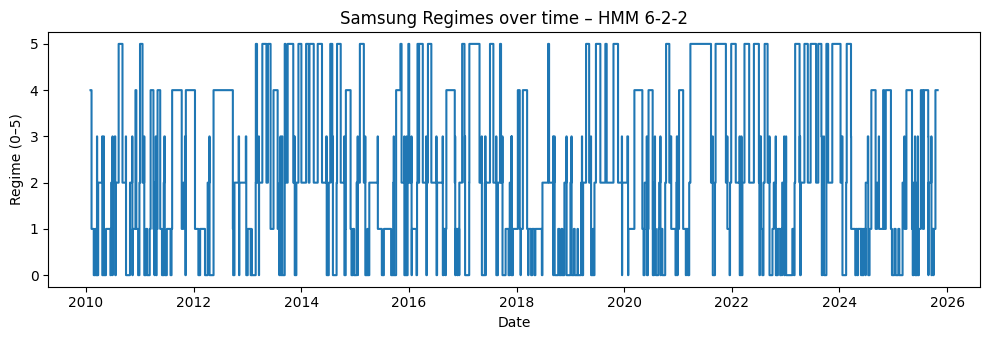

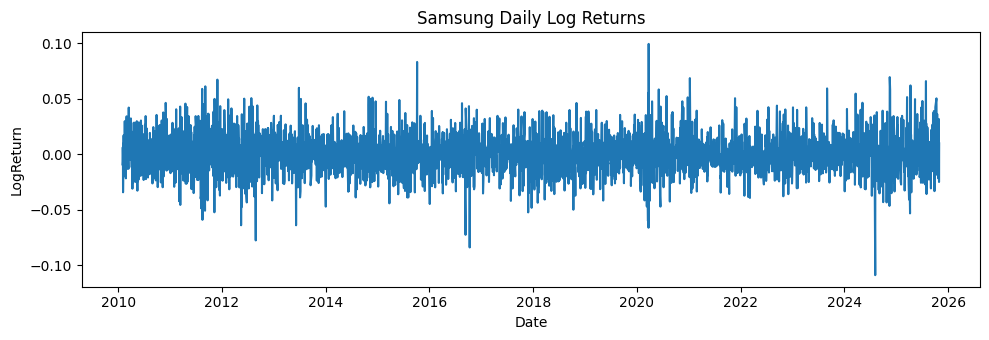

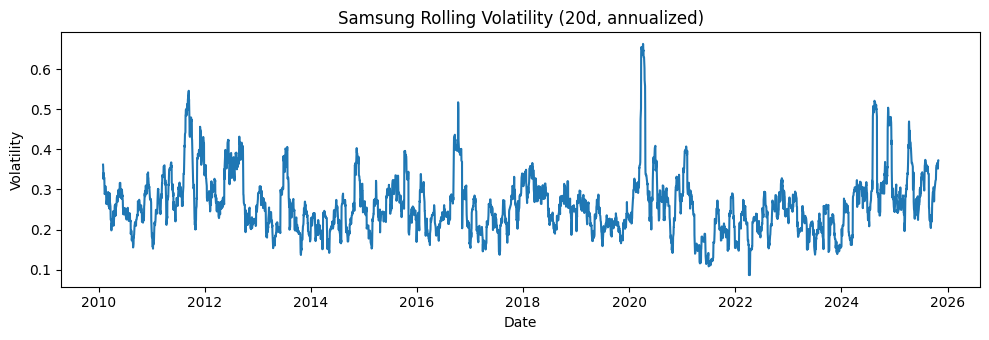

In [1]:
#Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GMMHMM
from sklearn.preprocessing import StandardScaler
import os

#Load data
df = pd.read_csv(r'Samsung_clean.csv')
df.columns = [c.strip().replace(' ', '_') for c in df.columns]

date_col = 'Date' if 'Date' in df.columns else [c for c in df.columns if 'date' in c.lower()][0]
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
df = df.dropna(subset=[date_col]).sort_values(date_col).reset_index(drop=True)

close_candidates = ['Adj_Close','AdjClose','Close','close','Price','price']
close_col = None
for c in df.columns:
    if c in close_candidates or c.lower() in ['close','adj close','adj_close','price']:
        close_col = c; break
if close_col is None:
    close_col = df.select_dtypes(include=[np.number]).columns[0]  # fallback

# 2 features: LogReturn & Rolling Volatility (20d, annualized)
df['LogReturn'] = np.log(df[close_col]).diff()
df['Volatility'] = df['LogReturn'].rolling(20).std() * np.sqrt(252)
df = df.dropna(subset=['LogReturn','Volatility']).reset_index(drop=True)
df.rename(columns={date_col: 'Date'}, inplace=True)

X_raw = df[['LogReturn','Volatility']].values
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)   
lengths = [len(X)]

# HMM 6:2:2
model = GMMHMM(
    n_components=6,   
    n_mix=2,            
    covariance_type='diag',
    n_iter=200,
    tol=1e-3,
    random_state=42,
    verbose=False
)
model.fit(X, lengths)

df['Regime'] = model.predict(X)

print("Transition matrix (6x6):")
print(np.round(model.transmat_, 3))

# Means 
orig_means = []
for s in range(model.n_components):
    mix_means = []
    for m in range(model.n_mix):
        mu_scaled = model.means_[s][m]           
        mu_orig = scaler.inverse_transform(mu_scaled.reshape(1,-1)).ravel()
        mix_means.append(mu_orig)
    orig_means.append(mix_means)
    print(f"State {s} mixture means (LogReturn, Volatility) in original units:")
    for m, mu in enumerate(mix_means):
        print(f"  - mix {m}: [{mu[0]:+.5f}, {mu[1]:.4f}]")

share = (df['Regime'].value_counts(normalize=True).sort_index()*100).round(2)
summary = pd.DataFrame({'Regime': share.index, 'Share_%': share.values})
print("\nTime share per Regime (%):\n", summary)

# Vẽ biểu đồ
plt.figure(figsize=(10,3.5))
plt.plot(df['Date'], df['Regime'], drawstyle='steps-post')
plt.title('Samsung Regimes over time – HMM 6-2-2')
plt.xlabel('Date'); plt.ylabel('Regime (0–5)')
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,3.5))
plt.plot(df['Date'], df['LogReturn'])
plt.title('Samsung Daily Log Returns')
plt.xlabel('Date'); plt.ylabel('LogReturn')
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,3.5))
plt.plot(df['Date'], df['Volatility'])
plt.title('Samsung Rolling Volatility (20d, annualized)')
plt.xlabel('Date'); plt.ylabel('Volatility')
plt.tight_layout(); plt.show()

# Lưu kết quả
out_path = os.path.join(os.path.dirname(r'Samsung_clean.csv'), 'samsung_hmm622_regimes.csv')
df.to_csv(out_path, index=False)